# AirBnB Sydney Price Forecasting

In [129]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
# this is to clear the warnings from this page, usually we should leave this on

In [130]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [131]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# EDA

In [132]:
#Below function drops the $ and other symbols from price, etc. and renders them as floats.

In [133]:
def fixsymbols(d):
    if d is train:
        d[['price','host_response_rate','host_acceptance_rate']]=d[['price','host_response_rate','host_acceptance_rate']].replace({'\$': '', ',': '','\%':''}, regex=True)
        d['price'] = d['price'].astype(float)
    elif d is test:
        d[['host_response_rate','host_acceptance_rate']]=d[['host_response_rate','host_acceptance_rate']].replace({'\$': '', ',': '','\%':''}, regex=True)
    else:
        print('Invalid data set.')

In [134]:
fixsymbols(train)
fixsymbols(test)

In [135]:
print(train['price'].skew())
print(train['price'].kurtosis())

5.7035509554419335
52.62609840971898


In [136]:
#Taking the log and YJ of price and comparing these.

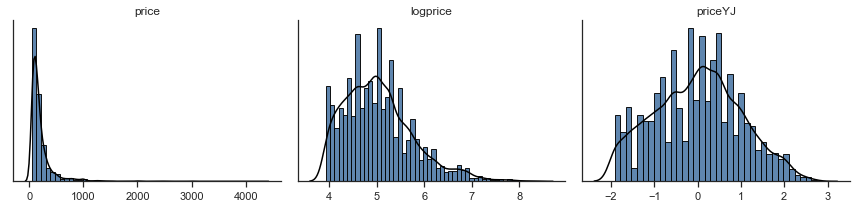

In [137]:
from sklearn.preprocessing import PowerTransformer

train['logprice'] = np.log(train['price'])

yjp = PowerTransformer(method='yeo-johnson') # YJ is the default, this function also does Box-Cox
train['priceYJ'] = yjp.fit_transform(train[['price']])

from statlearning import plot_dists
plot_dists(train[['price','logprice','priceYJ']]) 
plt.show()

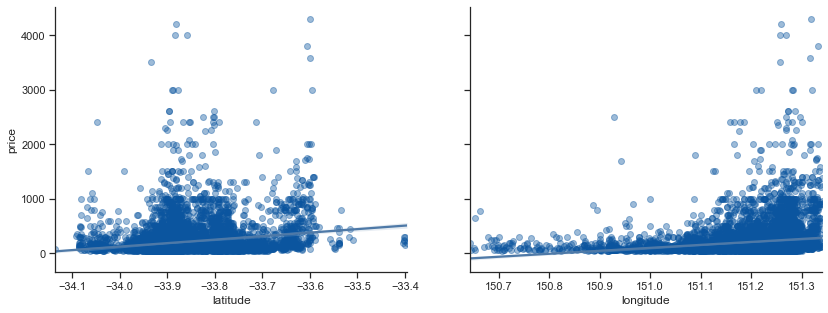

In [138]:
g = sns.pairplot(train, kind='reg', x_vars=['latitude','longitude'],y_vars='price',
                   plot_kws={'scatter_kws' :{'color': sns.color_palette('Blues')[-1], 'alpha': 0.4}})
g.fig.set_size_inches(13,5)

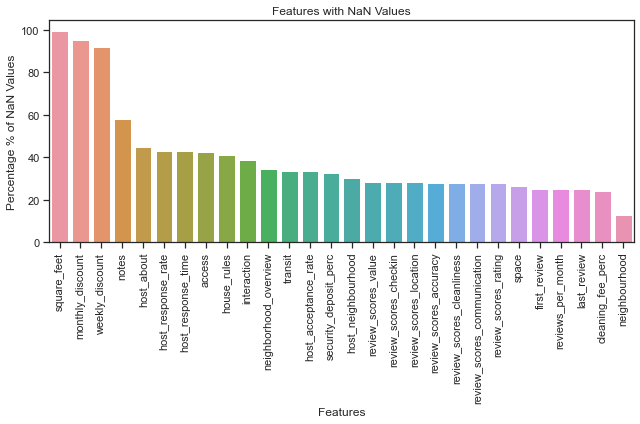

In [139]:
#Find all features with NaN values
NaN_values = train.isnull().sum().sort_values(ascending=False)[:28]

fig, ax = plt.subplots(1,1, figsize = (9, 6))
sns.barplot(x=NaN_values.index, y=NaN_values/train.shape[0]*100)
plt.xticks(rotation='90')
plt.xlabel('Features')
plt.ylabel('Percentage % of NaN Values')
plt.title('Features with NaN Values')
plt.tight_layout()
plt.savefig('NaNValues.png')

In [140]:
#The below code creates an array imputequantvars which shows all the quantitative variables that need imputing (have NAs).
#The array imputeobjvars shows all the non-quantitative variables that need imputing (have NAs).

In [141]:
imputevars = train.isnull().sum().sort_values(ascending=False)[train.isnull().sum().sort_values(ascending=False)>0].index.values

imputequantvars = []
imputeobjvars = []
for i in imputevars:
    if train.dtypes[i] != object:
        imputequantvars.append(i)
    if train.dtypes[i] == object:
        imputeobjvars.append(i)

# Feature Engineering

#### Data Mining 

In [142]:
# Just an idea
# Best hosts could be considered as the ones that maximise revenue (no.visits * price).
# There is no visitor count but there is a number of reviews.
# I read somewhere that airbnb thinks that 70% of visits leave a review
# revenue per month of listing as new listings won't have as many reviews but may still be successful
train['revenue_per_month'] = train['price']*(train['reviews_per_month']/0.7)
train = train[train.revenue_per_month.notna()]

### Imputing 'object' type variables

In [143]:
imputeobjvars
#These all need imputing. Below we will make a variable that records whether or not they are blanks and
#fills blanks with 'blank'

['notes',
 'host_about',
 'host_response_rate',
 'host_response_time',
 'access',
 'house_rules',
 'interaction',
 'neighborhood_overview',
 'transit',
 'host_acceptance_rate',
 'host_neighbourhood',
 'space',
 'first_review',
 'last_review',
 'neighbourhood',
 'zipcode',
 'host_location',
 'city']

In [144]:
#HOST RESPONSE RATE is not an object! It is actually an int.

#we will fill it with zeros because a NA response rate probably means no response
train.host_response_rate.fillna(0,inplace=True)
train.host_response_rate = train.host_response_rate.astype(int)

test.host_response_rate.fillna(0,inplace=True)
test.host_response_rate = test.host_response_rate.astype(int)

In [145]:
pd.unique(train.host_response_time)

array(['within a few hours', 'within an hour', nan, 'within a day',
       'a few days or more'], dtype=object)

In [146]:
#HOST RESPONSE TIME is an ordinal variable

train.host_response_time.fillna(0,inplace=True)
train.host_response_time = np.where(train.host_response_time=='a few days or more',1,train.host_response_time)
train.host_response_time = np.where(train.host_response_time=='within a day',2,train.host_response_time)
train.host_response_time = np.where(train.host_response_time=='within a few hours',3,train.host_response_time)
train.host_response_time = np.where(train.host_response_time=='within an hour',4,train.host_response_time)

train.host_response_time = train.host_response_time.astype(int)

#HOST RESPONSE TIME is an ordinal variable

test.host_response_time.fillna(0,inplace=True)
test.host_response_time = np.where(test.host_response_time=='a few days or more',1,test.host_response_time)
test.host_response_time = np.where(test.host_response_time=='within a day',2,test.host_response_time)
test.host_response_time = np.where(test.host_response_time=='within a few hours',3,test.host_response_time)
test.host_response_time = np.where(test.host_response_time=='within an hour',4,test.host_response_time)

test.host_response_time = test.host_response_time.astype(int)

In [147]:
train.host_acceptance_rate_blank = np.where(train.host_acceptance_rate.isna()==True,1,0)
train.host_acceptance_rate = train.host_acceptance_rate.fillna(0)
train.host_acceptance_rate = train.host_acceptance_rate.astype(int)

test.host_acceptance_rate_blank = np.where(test.host_acceptance_rate.isna()==True,1,0)
test.host_acceptance_rate = test.host_acceptance_rate.fillna(0)
test.host_acceptance_rate = test.host_acceptance_rate.astype(int)

In [148]:
#First Review and Last Review are dates. I will make a variable showing the gap between them.

In [149]:
train.first_review.fillna('2000-01-01',inplace=True)
test.first_review.fillna('2000-01-01',inplace=True)

In [150]:
train.first_review = pd.to_datetime(train.first_review)
test.first_review = pd.to_datetime(test.first_review)

In [151]:
train.last_review.fillna('2000-01-01',inplace=True)
test.last_review.fillna('2000-01-01',inplace=True)

In [152]:
train.last_review = pd.to_datetime(train.last_review)
test.last_review = pd.to_datetime(test.last_review)

In [153]:
train.reviewtimegap = train.last_review - train.first_review
test.reviewtimegap = test.last_review - test.first_review

In [154]:
train.reviewtimegap=train.reviewtimegap.astype(int)
test.reviewtimegap=test.reviewtimegap.astype(int)

In [155]:
#The below function makes a variable for each object variable that still remains and needs imputing
#and has NA values.

In [156]:
imputeobjvars

['notes',
 'host_about',
 'host_response_rate',
 'host_response_time',
 'access',
 'house_rules',
 'interaction',
 'neighborhood_overview',
 'transit',
 'host_acceptance_rate',
 'host_neighbourhood',
 'space',
 'first_review',
 'last_review',
 'neighbourhood',
 'zipcode',
 'host_location',
 'city']

In [157]:
imputeobjvars = np.delete(imputeobjvars,[2,3,9,12,13])

In [158]:
def imputeobjs(d):
    for i in imputeobjvars:
        if d is train or d is test:
            d[i+'_blank'] = ''
            d[i+'_blank'] = np.where(d[i].isna()==True,1,0)
            d[i] = np.where(d[i].isna()==True,'Blank',d.name.values)

In [159]:
imputeobjs(train)
imputeobjs(test)

### Imputing quantitative variables logically

In [160]:
imputequantvars

['square_feet',
 'monthly_discount',
 'weekly_discount',
 'security_deposit_perc',
 'review_scores_value',
 'review_scores_checkin',
 'review_scores_location',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_rating',
 'reviews_per_month',
 'cleaning_fee_perc',
 'beds',
 'bedrooms',
 'bathrooms']

In [161]:
#I have an idea -- maybe places with square feet listed have higher value?
#Let's impute all NAs as 0 and add a dummy for this.

#For all the above quant variables except for beds, bedrooms and bathrooms I want to impute with zeros. EVEN square feet.

In [162]:
imputequantvars = imputequantvars[:-3]

In [163]:
#Below is a function that will impute all the ones I want.

In [164]:
def imputequants(d):
    for i in imputequantvars:
        if d is train or d is test:
            d[i+'_blank'] = np.where(d[i].isna()==True,1,0)
            d[i] = d[i].fillna(0)
            d[i] = d[i].astype(int)

In [165]:
imputequants(train)
imputequants(test)

## Making new dummy variables

#### Neighbourhood binning

In [166]:
# Fill neighbourhood NaN
train['neighbourhood_cleansed']=train['neighbourhood_cleansed'].fillna(train['city'])

# This code bins very low frequency neighbourhoods into an 'Other' field - interesting to discuss 
series = pd.value_counts(train.neighbourhood_cleansed)

In [167]:
mask = (series/series.sum() * 100).lt(0.03)
# # To replace df['column'] use np.where I.e 
train['neighbourhood_cleansed'] = np.where(train['neighbourhood_cleansed'].isin(series[mask].index),'Other',train['neighbourhood_cleansed'])

In [168]:
# Average price of neighbourhood ranked - starting to make sense
# We should bin based on this but need to consider how this will effect the test binning
bins = train.groupby("neighbourhood_cleansed").mean()['price'].sort_values(ascending=False)//50

In [169]:
bins

neighbourhood_cleansed
Pittwater           8.0
Mosman              5.0
Hunters Hill        5.0
Manly               5.0
Warringah           5.0
Waverley            4.0
Sutherland Shire    4.0
Lane Cove           4.0
Woollahra           4.0
Leichhardt          4.0
North Sydney        3.0
The Hills Shire     3.0
Randwick            3.0
City Of Kogarah     3.0
Willoughby          3.0
Sydney              3.0
Penrith             3.0
Canada Bay          3.0
Liverpool           3.0
Hurstville          3.0
Hornsby             2.0
Strathfield         2.0
Auburn              2.0
Rockdale            2.0
Fairfield           2.0
Ashfield            2.0
Marrickville        2.0
Camden              2.0
Ku-Ring-Gai         2.0
Ryde                2.0
Parramatta          2.0
Campbelltown        2.0
Canterbury          2.0
Botany Bay          2.0
Bankstown           2.0
Burwood             2.0
Holroyd             1.0
Blacktown           1.0
Name: price, dtype: float64

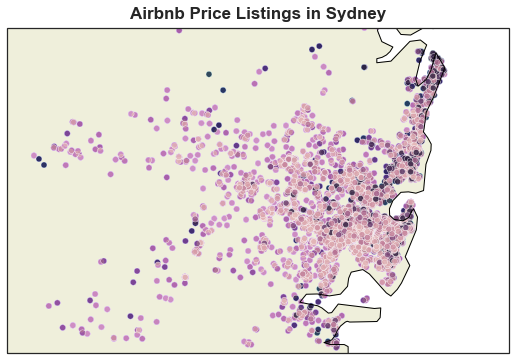

In [170]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText


def main():
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([151.45,150.6,-34.1,-33.55])


#     # Put a background image on for nice sea rendering.
#     ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')
    
    # Get latitude and longitude for each data point
    x, y = (train['longitude'].to_numpy(), train['latitude'].to_numpy())

#     # Scatter plot as heat map
    ax.scatter(x,y,c=(train['price']),
           edgecolors='none', cmap=plt.get_cmap('rainbow'), alpha=1)
    
    sns.scatterplot(x='longitude', y='latitude',hue='price', hue_norm=(0,450),alpha=0.8, data=train)
    plt.legend([],[], frameon=False)

#     # Add a text annotation for the license information to the
#     # the bottom right corner.
#     text = AnchoredText(r'$\mathcircled{{c}}$ {}; license: {}'
#                         ''.format(SOURCE, LICENSE),
#                         loc=4, prop={'size': 12}, frameon=True)
#     ax.add_artist(text)
    plt.title('Airbnb Price Listings in Sydney', fontsize=17, y=1.01, fontweight='bold')
    plt.show()
    
if __name__ == '__main__':
    main()

In [171]:
pd.unique(train.neighbourhood_cleansed)

def neighbourhoodbins(d):
    if d is train or d is test:
        
        d['neighbourhood_cleansed']=d['neighbourhood_cleansed'].fillna(d['city']) 
        series = pd.value_counts(d.neighbourhood_cleansed)
        
        mask = (series/series.sum() * 100).lt(0.03)
        d['neighbourhood_cleansed'] = np.where(d['neighbourhood_cleansed'].isin(series[mask].index),'Other',d['neighbourhood_cleansed'])
        
        for i in range(len(bins.index)):
            d.neighbourhood_cleansed = np.where(d.neighbourhood_cleansed==bins.index[i],bins[i],d.neighbourhood_cleansed)

In [172]:
neighbourhoodbins(train)
neighbourhoodbins(test)

train.neighbourhood_cleansed = train.neighbourhood_cleansed.astype(float)
test.neighbourhood_cleansed = test.neighbourhood_cleansed.astype(float)

### Here we carefully consider which categorical variables to include as dummies...

#### What do the most expensive places have in their summary?

In [173]:
train = pd.get_dummies(train,columns=['cancellation_policy','requires_license','host_is_superhost','host_identity_verified','property_type','bed_type','instant_bookable','is_business_travel_ready','require_guest_profile_picture','require_guest_phone_verification','host_response_time','is_location_exact','room_type'],drop_first=True)

In [174]:
test = pd.get_dummies(test,columns=['cancellation_policy','requires_license','host_is_superhost','host_identity_verified','property_type','bed_type','instant_bookable','is_business_travel_ready','require_guest_profile_picture','require_guest_phone_verification','host_response_time','is_location_exact','room_type'],drop_first=True)

#### Amenity dummies

In [175]:
#Below we define a function for rendering train and test amenity dummies.

In [176]:
#This simply adds up all the amenities to generate a score.

def amenityscore(d):
    
    amenitieslist = []

    for i in range(len(d.amenities.values)):
        k = d.amenities.values[i].replace('{','').replace('}','').replace('"','').split(',')
        for j in range(len(k)):
            if k[j] not in amenitieslist:
                amenitieslist.append(k[j])
    
    if d is train or d is test:
        d['amenityscore'] = 0
        for i in amenitieslist:
            d['amenityscore'] += np.where(d.amenities.str.contains(i,case=False),1,0)
        d['amenityscore'] += np.where(d.summary.str.contains('beach',case=False),1,0)
    else:
        print('Invalid entry, type train or test into the function.')

In [177]:
amenityscore(train)
amenityscore(test)

In [178]:
#AND/OR make a dummy for each amenity

def amenitify(d):
    
    amenitieslist = []

    for i in range(len(d.amenities.values)):
        k = d.amenities.values[i].replace('{','').replace('}','').replace('"','').split(',')
        for j in range(len(k)):
            if k[j] not in amenitieslist:
                amenitieslist.append(k[j])
    
    if d is train or d is test:
        for i in amenitieslist:
            d[i] = np.where(d.amenities.str.contains(i,case=False),1,0)
        d['beach'] = np.where(d.summary.str.contains('beach',case=False),1,0)
    else:
        print('Invalid entry, type train or test into the function.')

In [179]:
amenitify(train)
amenitify(test)

In [180]:
train['bedroomsXaccommodates'] = train['bedrooms']*train['accommodates']

In [181]:
test['bedroomsXaccommodates'] = test['bedrooms']*test['accommodates']

In [182]:
train['bedroomsXbathrooms'] = train['bedrooms']*train['bathrooms']

In [183]:
test['bedroomsXbathrooms'] = test['bedrooms']*test['bathrooms']

In [184]:
train['hotlatitude'] = np.where(((train['latitude']<-33.85)&(train['latitude']>-33.9))|((train['latitude']>-33.7)&(train['latitude']<-33.55)),1,0)

In [185]:
test['hotlatitude'] = np.where(((test['latitude']<-33.85)&(test['latitude']>-33.9))|((test['latitude']>-33.7)&(test['latitude']<-33.55)),1,0)

In [186]:
train['hotlongitude'] = np.where((train['longitude']>151.2),1,0)

In [187]:
test['hotlongitude'] = np.where((test['longitude']>151.2),1,0)

In [188]:
train['hotlatXhotlong'] = train['hotlatitude']*train['hotlongitude']
test['hotlatXhotlong'] = test['hotlatitude']*test['hotlongitude']

In [189]:
abs(train.corr()['logprice']).sort_values(ascending=False)[3:30].drop('revenue_per_month')

accommodates                                       0.679780
bedrooms                                           0.664572
bedroomsXaccommodates                              0.642417
bedroomsXbathrooms                                 0.629077
beds                                               0.619002
room_type_Private room                             0.580205
bathrooms                                          0.428830
guests_included                                    0.357145
neighbourhood_cleansed                             0.304222
Family/kid friendly                                0.270347
TV                                                 0.240464
amenityscore                                       0.238698
cancellation_policy_strict_14_with_grace_period    0.235938
security_deposit_perc_blank                        0.232616
longitude                                          0.228388
calculated_host_listings_count_private_rooms       0.217966
Crib                                    

In [190]:
train.isna().sum().sort_values()

name                      0
Baby bath                 0
Baby monitor              0
Barbecue utensils         0
Game console              0
                         ..
bedrooms                  3
bathrooms                 3
bedroomsXaccommodates     3
bedroomsXbathrooms        6
beds                     22
Length: 344, dtype: int64

In [191]:
features = train.columns.values

In [192]:
features = np.delete(features,np.where(features=='priceYJ'))
features = np.delete(features,np.where(features=='price'))

In [193]:
features = np.delete(features,np.where(features=='revenue_per_month'))

In [194]:
#AND/OR make a dummy for each verification mode

def verify(d):
    
    verifylist = []

    for i in range(len(d.host_verifications.values)):
        k = d.host_verifications.values[i].replace('"','').replace("'",'').replace(']','').replace('[','').split(',')
        for j in range(len(k)):
            if k[j] not in verifylist:
                verifylist.append(k[j])
    #return print(verifylist)
    if d is train or d is test:
        for i in verifylist:
            d[i] = np.where(d.host_verifications.str.contains(i,case=False),1,0)
    else:
        print('Invalid entry, type train or test into the function.')

In [195]:
verify(train)
verify(test)

In [196]:
train.host_since = pd.to_datetime(train.host_since)
test.host_since = pd.to_datetime(test.host_since)

In [197]:
train['hostlife']=train.host_since.max()-train.host_since
test['hostlife']=test.host_since.max()-test.host_since

In [198]:
train.host_since.fillna('2000-01-01',inplace=True)
test.host_since.fillna('2000-01-01',inplace=True)

In [199]:
train.hostlife=train.hostlife.astype(int)
test.hostlife=test.hostlife.astype(int)

In [200]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train[features], train['logprice'], test_size=0.20, random_state=1)

In [201]:
fullxtrain = train[np.delete(features,np.where(features=='logprice'))]
fullytrain = train['logprice']

In [204]:
from pandas_profiling import ProfileReport
print('Warning: Pandas Profiling can take several minutes.')
optimise = str(input('Would you like to profile? Answer \'C\' to continue.'))

if optimise.lower() == 'c':
    profile = ProfileReport(train, minimal=True)
    profile.to_widgets()
else:
    print('Profiling cancelled')

Would you like to profile? Answer 'C' to continue. n


Profiling cancelled


# Modelling

In [205]:
#One model must be a linear model. We will use an Elastic Net here.

In [206]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp =  IterativeImputer()
imp.fit(X_train[imputequantvars])
X_train[imputequantvars] = imp.transform(X_train[imputequantvars])
X_val[imputequantvars] = imp.transform(X_val[imputequantvars])

Should we be fitting the imputer to the test?

In [207]:
#imp.fit(test[imputequantvars])
test[imputequantvars] = imp.transform(test[imputequantvars])

In [208]:
fullxtrain[imputequantvars] = imp.fit_transform(fullxtrain[imputequantvars])

In [209]:
#Fixing variable skewness

In [210]:
skews = ['square_feet','weekly_discount','minimum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calculated_host_listings_count_shared_rooms']

In [211]:
yj = PowerTransformer(method='yeo-johnson')

X_train[skews]  = yj.fit_transform(X_train[skews])
X_val[skews] = yj.transform(X_val[skews])
test[skews] = yj.transform(test[skews])

In [212]:
#Dropping training outliers

In [213]:
fullxtrain[skews]  = yj.fit_transform(fullxtrain[skews])

## Outliers

In [214]:
quantitativevariables = []
for i in features:
    if train.dtypes[i] == int or train.dtypes[i] == float and i != 'logprice' and i!='revenue_per_month':
        quantitativevariables.append(i)

In [215]:
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

In [216]:
fullxtrain = fullxtrain.fillna(0)

In [217]:
test = test.fillna(0)

In [218]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(X_train[quantitativevariables], y_train)

y_fitted = ols.predict(X_train[quantitativevariables])
e = y_train - y_fitted

#e.reset_index(drop=True,inplace=True)

outliers = e.abs().sort_values().iloc[-10:] # retrieves the indexes for the largest 10 residuals

In [219]:
outlierlist = outliers.index.values

In [220]:
for i in outlierlist:
    X_train['outlier'] = np.where(X_train.index==i,1,0)
    fullxtrain['outlier'] = np.where(fullxtrain.index==i,1,0)

## Elastic Net

In [221]:
features = abs(train.corr()['logprice']).sort_values(ascending=False)[3:].index.values

In [222]:
features=np.delete(features,np.where(features=='property_type_Castle')) #castle is causing it to act up for the test
features=np.delete(features,np.where(features=='revenue_per_month')) #castle is causing it to act up for the test

In [223]:
badfeatures = ['Nespresso machine', 'Natural gas barbeque', 'Sonos sound system', 'Heated pool', 'Projector', 'Driveway parking', 'Beach chairs']
#These features don't exist in the test and so will be deleted.
for i in badfeatures:
    features=np.delete(features,np.where(features==i)) # is causing it to act up for the test
morebadfeatures = [' zhima_selfie', ' sent_id', ' reviews', ' manual_online', ' google', ' weibo', ' jumio', 'phone', 'offline_government_id', ' government_id', ' manual_offline', ' selfie', ' kba', 'jumio', 'reviews', ' identity_manual', 'hostlife', ' work_email', ' phone', ' offline_government_id', ' sesame', ' facebook', 'email', ' sesame_offline', 'facebook']
for i in morebadfeatures:
    features=np.delete(features,np.where(features==i)) # is causing it to act up for the test

In [224]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler() #scaling

X_train_scaled = scaler.fit_transform(X_train[features])
X_train = pd.DataFrame(X_train_scaled)

X_val_scaled = scaler.transform(X_val[features])
X_val = pd.DataFrame(X_val_scaled)

In [225]:
test_scaled = scaler.transform(test[features])
test = pd.DataFrame(test_scaled)

In [226]:
fullxtrain = pd.DataFrame(scaler.fit_transform(fullxtrain[features]))

In [227]:
from sklearn.linear_model import ElasticNetCV
enet_cv = ElasticNetCV(l1_ratio=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1], cv=5)
enet_cv.fit(X_train,np.ravel(y_train))

ElasticNetCV(cv=5,
             l1_ratio=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                       0.95, 0.99, 1])

In [228]:
enet_cv.l1_ratio_

1.0

In [229]:
enet_cv.alpha_

0.0028861641656963383

In [230]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha = enet_cv.alpha_, l1_ratio = enet_cv.l1_ratio_)

In [231]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kf=KFold(5) 
scores = cross_val_score(enet, X_val, y_val, cv=kf, scoring = 'neg_mean_squared_error')

# print the score for each fold
print(np.sqrt(-scores).round(4))
print((sum(np.sqrt(-scores))/len(np.sqrt(-scores))).round(4))
print('RMSE score for Elastic Net model')

[0.3353 0.335  0.3753 0.3212 0.3308]
0.3395
RMSE score for Elastic Net model


In [232]:
enet.fit(X_train,y_train)

ElasticNet(alpha=0.0028861641656963383, l1_ratio=1.0)

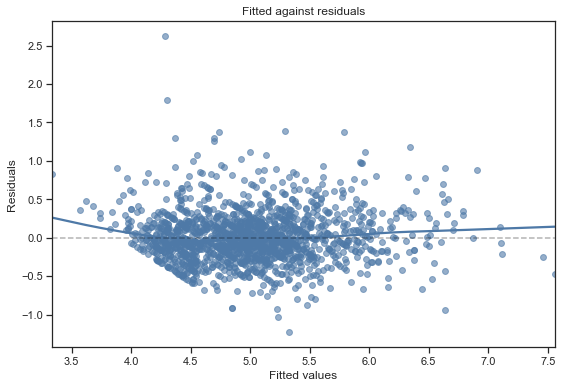

In [233]:
#interpretable fitted and resid
# fitted = np.exp(enet_cv.predict(X_val))
# resid = np.exp(y_val) - np.exp(enet_cv.predict(X_val))
fitted = enet.predict(X_val)
resid = y_val - enet.predict(X_val)

fig, ax= plt.subplots()
sns.regplot(fitted, resid, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Fitted against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--') 
#EXOGENEITY plot

In [234]:
elasticnetvars = pd.DataFrame(enet.coef_.round(3), index = features).T.where(pd.DataFrame(enet.coef_.round(3), index = features).T!=0).notnull()

In [235]:
enetselect = elasticnetvars.iloc[0][elasticnetvars.iloc[0].values==True].index.values

In [236]:
np.where(elasticnetvars==True)[1]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  18,  19,  20,  21,  23,  24,  25,  26,  28,  30,  31,
        32,  35,  40,  41,  42,  44,  45,  46,  47,  48,  54,  55,  62,
        67,  73,  75,  76,  85,  88,  90,  94,  95,  97, 104, 105, 108,
       109, 110, 124, 127, 131, 132, 134, 139, 140, 151, 165, 169, 179,
       190, 198, 205, 237, 239, 240, 254, 277, 278, 291])

In [237]:
len(enetselect)

75

In [238]:
enetselect

array(['accommodates', 'bedrooms', 'bedroomsXaccommodates',
       'bedroomsXbathrooms', 'beds', 'room_type_Private room',
       'bathrooms', 'guests_included', 'neighbourhood_cleansed',
       'Family/kid friendly', 'TV', 'amenityscore',
       'cancellation_policy_strict_14_with_grace_period',
       'security_deposit_perc_blank', 'longitude', 'extra_people_perc',
       'Dishwasher', 'Indoor fireplace', 'cleaning_fee_perc_blank',
       'hotlongitude', 'Heating', 'property_type_House', 'Cable TV',
       'Air conditioning', 'calculated_host_listings_count_entire_homes',
       'BBQ grill', 'latitude', 'host_listings_count', 'Smoking allowed',
       'Lock on bedroom door', 'Iron', 'hotlatXhotlong', 'Dryer',
       'Coffee maker', 'Pool', 'availability_365',
       'property_type_Apartment', 'Hair dryer', 'Fire extinguisher',
       'hotlatitude', 'house_rules_blank', 'Beachfront',
       'Dishes and silverware', 'First aid kit', 'notes_blank',
       'Microwave', 'host_id', 'Waterf

In [284]:
enet.fit(fullxtrain,fullytrain)

ElasticNet(alpha=0.0028861641656963383, l1_ratio=1.0)

In [285]:
#predictions = yjp.inverse_transform(enet_cv.predict(test).reshape(-1,1))
predictions = np.round(np.exp(enet.predict(test)),2)

In [286]:
np.isnan(predictions).sum()

0

In [287]:
np.where(np.isnan(predictions)==True)

(array([], dtype=int64),)

In [288]:
my_submission = pd.DataFrame({'id': test.index, 'price': predictions.ravel()})
my_submission.to_csv('submission.csv', index=False)

In [243]:
enet_cv.coef_[enet_cv.coef_!=0]

array([ 1.44101122e-01,  1.33250452e-01, -3.63349653e-02,  7.62526235e-02,
        7.89937619e-03, -4.62849608e-01, -8.67279493e-03,  3.59084154e-03,
        2.79606144e-02,  1.13285401e-02,  3.49333742e-02,  1.38981100e-02,
        5.74739564e-02, -6.25050203e-02,  5.69165200e-02, -3.61235687e-02,
        4.49792524e-02,  3.95572228e-02, -1.51207761e-01,  2.71031709e-02,
        3.70857132e-03,  3.05443821e-02,  3.82751428e-02,  5.61184064e-02,
        2.57758917e-03,  2.06895770e-02,  5.29086845e-03, -9.75963371e-04,
       -6.02527570e-17, -2.01244156e-04, -2.69296742e-02, -1.81601914e-02,
        6.27051737e-03,  5.46134718e-02,  2.32771247e-02,  2.15145981e-02,
        3.26408718e-02,  4.75552807e-02, -3.30615022e-03,  8.53249431e-03,
        7.89389960e-04,  3.70736376e-02, -8.78994205e-04,  2.28625361e-02,
       -2.09412839e-03,  2.25209107e-02, -2.33080230e-02, -1.80473587e-02,
       -4.01637091e-03,  2.11709825e-02, -8.86795927e-03, -7.84073334e-04,
       -6.79814700e-03, -

## Ordinary Least Squares
We will take the same variables selected above as the L1 ratio = 1, meaning that LASSO has selected these variables and not Ridge.

In [244]:
OLSfeatures = np.where(elasticnetvars==True)[1]

In [245]:
ols = LinearRegression()
ols.fit(X_train[OLSfeatures], y_train)

LinearRegression()

In [246]:
kf=KFold(5) 
scores = cross_val_score(ols, X_val[OLSfeatures], y_val, cv=kf, scoring = 'neg_mean_squared_error')

# print the score for each fold
print(np.sqrt(-scores).round(4))
print((sum(np.sqrt(-scores))/len(np.sqrt(-scores))).round(4))
print('RMSE score for Ordinary Least Squares model')

[0.3428 0.3355 0.3764 0.3237 0.3318]
0.342
RMSE score for Ordinary Least Squares model


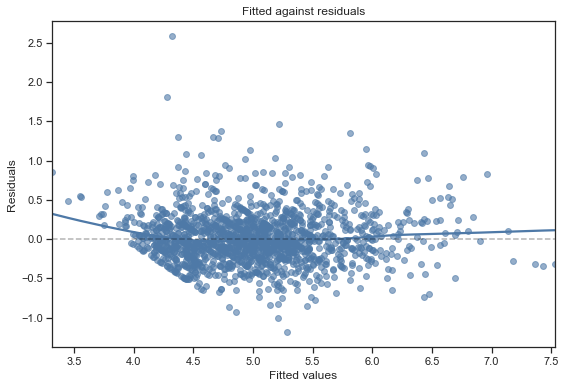

In [247]:
fitted = ols.predict(X_val[OLSfeatures])
resid = y_val - ols.predict(X_val[OLSfeatures])

fig, ax= plt.subplots()
sns.regplot(fitted, resid, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Fitted against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--') 
#EXOGENEITY plot

## Ridge
We will take the same variables selected before as the L1 ratio = 1, meaning that LASSO has selected these variables and not Ridge.

In [248]:
OLSfeatures = np.where(elasticnetvars==True)[1]

In [249]:
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas=np.arange(150,300)*0.1, cv=5)
ridge_cv.fit(X_train[OLSfeatures],np.ravel(y_train))

RidgeCV(alphas=array([15. , 15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16. ,
       16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17. , 17.1,
       17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18. , 18.1, 18.2,
       18.3, 18.4, 18.5, 18.6, 18.7, 18.8, 18.9, 19. , 19.1, 19.2, 19.3,
       19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20. , 20.1, 20.2, 20.3, 20.4,
       20.5, 20.6, 20.7, 20.8, 20.9, 21. , 21.1, 21.2, 21.3, 21.4, 21.5,
       21.6,...
       22.7, 22.8, 22.9, 23. , 23.1, 23.2, 23.3, 23.4, 23.5, 23.6, 23.7,
       23.8, 23.9, 24. , 24.1, 24.2, 24.3, 24.4, 24.5, 24.6, 24.7, 24.8,
       24.9, 25. , 25.1, 25.2, 25.3, 25.4, 25.5, 25.6, 25.7, 25.8, 25.9,
       26. , 26.1, 26.2, 26.3, 26.4, 26.5, 26.6, 26.7, 26.8, 26.9, 27. ,
       27.1, 27.2, 27.3, 27.4, 27.5, 27.6, 27.7, 27.8, 27.9, 28. , 28.1,
       28.2, 28.3, 28.4, 28.5, 28.6, 28.7, 28.8, 28.9, 29. , 29.1, 29.2,
       29.3, 29.4, 29.5, 29.6, 29.7, 29.8, 29.9]),
        cv=5)

In [250]:
ridge_cv.alpha_

22.700000000000003

In [251]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=ridge_cv.alpha_)

In [252]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kf=KFold(5) 
scores = cross_val_score(ridge, X_val[OLSfeatures], y_val, cv=kf, scoring = 'neg_mean_squared_error')

# print the score for each fold
print(np.sqrt(-scores).round(4))
print((sum(np.sqrt(-scores))/len(np.sqrt(-scores))).round(4))
print('RMSE score for Ridge model')

[0.3375 0.3352 0.3756 0.3229 0.3317]
0.3406
RMSE score for Ridge model


## XGBoost

### Bayesian hyperparameter optimisation for XGB

In [253]:
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

In [254]:
from xgboost import XGBRegressor

model = XGBRegressor()

search_space = {
    'reg_lambda': Real(1e-10, 1e12, 'log-uniform'),
    'learning_rate': Real(0.005, 0.1),
    'n_estimators' : Integer(100, 5000),
    'max_depth' : Integer(2, 8),
    'subsample' : Real(0.5, 1.0),
    'colsample_bytree' : Real(0.25, 1.0),
}

xgb_opt =  BayesSearchCV(model, search_space, cv = 5,  n_iter= 8, scoring = 'neg_mean_squared_error', n_jobs=-1)

In [255]:
#Thinking about making this as a warning.

print('Warning: Optimising and fitting XGBoost will take at least 40 minutes.')
optimise = str(input('Would you like to optimise and fit XGBoost? Answer \'C\' to continue.'))

if optimise.lower() == 'c':
    model = xgb_opt.fit(X_train, y_train)
    xgb_opt.best_params_

Would you like to optimise and fit XGBoost? Answer 'C' to continue. c


In [256]:
xgb_opt.best_params_

OrderedDict([('colsample_bytree', 0.6585666723543374),
             ('learning_rate', 0.02100437221055008),
             ('max_depth', 4),
             ('n_estimators', 2583),
             ('reg_lambda', 1.2994805179302653e-08),
             ('subsample', 0.6757498243587916)])

In [257]:
#Why run the same 40 minute optimiser over and over? These are the best params.

xgboost = xgb_opt.best_estimator_

In [258]:
score = cross_val_score(xgboost, X_val, y_val, cv=kf, scoring = 'neg_mean_squared_error')
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
print(np.sqrt(-score)) #scores for each fold

xgboost: -0.0979 (0.0122)
[0.28633611 0.3105886  0.34594802 0.31012361 0.30812311]


In [259]:
print(np.mean(np.sqrt(-score)))

0.3122238920801711


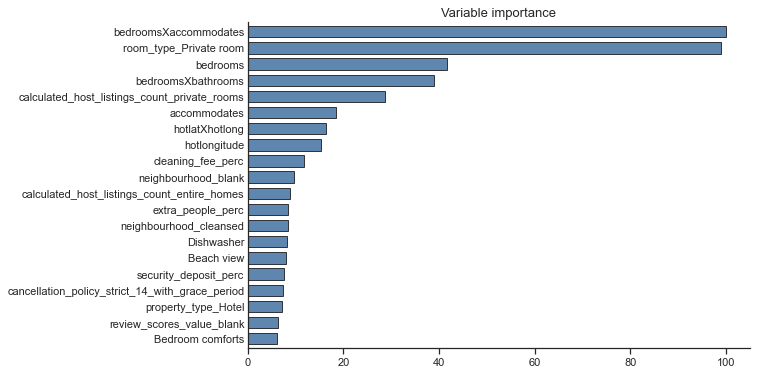

In [260]:
from statlearning import plot_feature_importance
plot_feature_importance(xgb_opt.best_estimator_, labels=features)
plt.show()

In [280]:
testxgb = xgboost.fit(fullxtrain, fullytrain)

In [282]:
#predictions = yjp.inverse_transform(enet_cv.predict(test).reshape(-1,1))
predictions = np.round(np.exp(testxgb.predict(test)),2)

In [283]:
my_submission = pd.DataFrame({'id': test.index, 'price': predictions.ravel()})
my_submission.to_csv('submission.csv', index=False)

## LightGBM

In [263]:
import lightgbm as lgb

In [264]:
model = lgb.LGBMRegressor(objective='regression')

search_space = {
    'learning_rate': Real(0.005,0.1), # uniform distribution between 0.005 and 0.1
    'n_estimators' : Integer(100, 2501), # discrete uniform distribution between 100 and 2500
    'num_leaves' : Integer(2, 65), # discrete uniform distribution between 2 and 4
    'subsample' : Real(0.5, 1), # uniform distribution between 0.5 and 1
}


lbst = BayesSearchCV(model, search_space, n_iter = 32, cv = 5, n_jobs=-1, random_state=1) #CHANGE NUMBER OF ITERATIONS for OPTIMALITY
lbst.fit(X_train, y_train)


print('Best parameters found by Bayes search:', lbst.best_params_, '\n')

Best parameters found by Bayes search: OrderedDict([('learning_rate', 0.08838008753245956), ('n_estimators', 963), ('num_leaves', 4), ('subsample', 0.7854148780763127)]) 



In [265]:
lgb = lbst.best_estimator_

In [266]:
score = cross_val_score(lgb, X_val, y_val, cv=kf, scoring = 'neg_mean_squared_error')
print("LightGBM: {:.4f} ({:.4f})".format(score.mean(), score.std()))
print(np.sqrt(-score)) #scores for each fold

LightGBM: -0.1008 (0.0141)
[0.29353705 0.3197337  0.35638825 0.30437453 0.31011024]


In [267]:
print(np.mean(np.sqrt(-score)))

0.31682875376343217


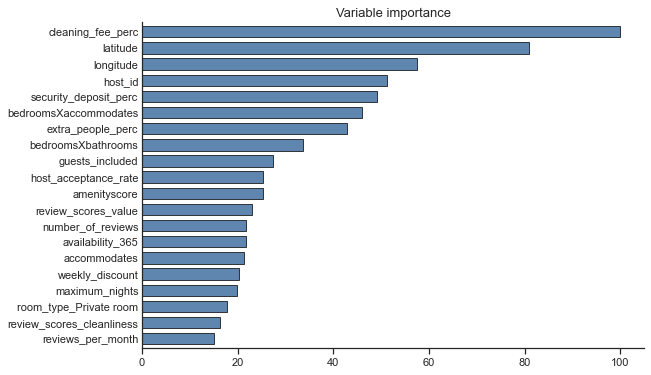

In [268]:
from statlearning import plot_feature_importance
plot_feature_importance(lgb, labels=features)
plt.show()

In [269]:
#predictions = np.round(yj.inverse_transform(enet_cv.predict(test).reshape(-1,1)),2)
predictions = np.round(np.exp(lgb.predict(test)),2)

In [270]:
my_submission = pd.DataFrame({'id': test.index, 'price': predictions})
my_submission.to_csv('submission.csv', index=False)

## Model Stacking

In [271]:
stack_train = X_train.values
stack_val = X_val.values
stack_y_val = y_val.values
stack_y_train = y_train.values

In [272]:
from mlxtend.regressor import StackingCVRegressor
 
stack = StackingCVRegressor(regressors=[lgb, enet, xgboost], meta_regressor=ElasticNet(alpha = enet_cv.alpha_, l1_ratio = enet_cv.l1_ratio_), n_jobs=-1,
                           cv=5, use_features_in_secondary=True)
#modelstack = stack.fit(stack_train, stack_y_train)

In [274]:
score = cross_val_score(stack, stack_val, stack_y_val, cv=kf, scoring = 'neg_mean_squared_error')
print("stack: {:.4f} ({:.4f})".format(score.mean(), score.std()))
print(np.sqrt(-score)) #scores for each fold

stack: -0.0962 (0.0141)
[0.28539588 0.31069724 0.35016403 0.2986285  0.30231729]


In [275]:
print(np.round(np.sqrt(-score),4))

[0.2854 0.3107 0.3502 0.2986 0.3023]


In [276]:
np.mean(np.sqrt(-score))

0.30944058692793924

In [277]:
teststack = stack.fit(fullxtrain, fullytrain)

In [278]:
stacktest=test.values
predictions = np.round(np.exp(teststack.predict(stacktest)),2)

In [279]:
my_submission = pd.DataFrame({'id': test.index, 'price': predictions.ravel()})
my_submission.to_csv('submission.csv', index=False)

# Data Mining

In [366]:
train['logrevenue_per_month'] = np.log(train['revenue_per_month'])

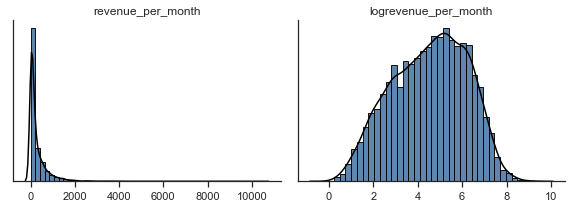

In [367]:
from statlearning import plot_dists
plot_dists(train[['revenue_per_month','logrevenue_per_month']]) 
plt.show()

In [332]:
#These are the values for the data mining

In [368]:
features = train.columns.values

In [369]:
features = np.delete(features,np.where(features=='priceYJ'))
features = np.delete(features,np.where(features=='logprice'))

In [370]:
features = np.delete(features,np.where(features=='revenue_per_month'))
features = np.delete(features,np.where(features=='logrevenue_per_month'))

In [371]:
from sklearn.model_selection import train_test_split
X_tr_mine, X_val_mine, y_tr_mine, y_val_mine = train_test_split(train[features], train['logrevenue_per_month'], test_size=0.20, random_state=1)

In [372]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp =  IterativeImputer()
imp.fit(X_tr_mine[imputequantvars])
X_tr_mine[imputequantvars] = imp.transform(X_tr_mine[imputequantvars])
X_val_mine[imputequantvars] = imp.transform(X_val_mine[imputequantvars])

Should we be fitting the imputer to the test?

In [373]:
#Fixing variable skewness

In [374]:
skews = ['square_feet','weekly_discount','minimum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calculated_host_listings_count_shared_rooms']

In [375]:
yj = PowerTransformer(method='yeo-johnson')

X_tr_mine[skews]  = yj.fit_transform(X_tr_mine[skews])
X_val_mine[skews] = yj.transform(X_val_mine[skews])

## Outliers

In [376]:
quantitativevariables = []
for i in features:
    if train.dtypes[i] == int or train.dtypes[i] == float and i!='revenue_per_month' and i!='logrevenue_per_month':
        quantitativevariables.append(i)

In [377]:
X_tr_mine = X_tr_mine.fillna(0)
X_val_mine = X_val_mine.fillna(0)

In [378]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(X_tr_mine[quantitativevariables], y_tr_mine)

y_fitted = ols.predict(X_tr_mine[quantitativevariables])
e = y_train - y_fitted

#e.reset_index(drop=True,inplace=True)

outliers = e.abs().sort_values().iloc[-10:] # retrieves the indexes for the largest 10 residuals

In [379]:
outlierlist = outliers.index.values

In [380]:
for i in outlierlist:
    X_tr_mine['outlier'] = np.where(X_tr_mine.index==i,1,0)

In [381]:
features = abs(train.corr()['logrevenue_per_month']).sort_values(ascending=False)[1:].index.values

In [382]:
features=np.delete(features,np.where(features=='priceYJ'))
features=np.delete(features,np.where(features=='revenue_per_month'))
features=np.delete(features,np.where(features=='logprice')) #price is still a variable that can be used! just not YJ or log

In [383]:
badfeatures = ['Nespresso machine', 'Natural gas barbeque', 'Sonos sound system', 'Heated pool', 'Projector', 'Driveway parking', 'Beach chairs']
#These features don't exist in the test and so will be deleted.
for i in badfeatures:
    features=np.delete(features,np.where(features==i)) # is causing it to act up for the test
morebadfeatures = [' zhima_selfie', ' sent_id', ' reviews', ' manual_online', ' google', ' weibo', ' jumio', 'phone', 'offline_government_id', ' government_id', ' manual_offline', ' selfie', ' kba', 'jumio', 'reviews', ' identity_manual', 'hostlife', ' work_email', ' phone', ' offline_government_id', ' sesame', ' facebook', 'email', ' sesame_offline', 'facebook']
for i in morebadfeatures:
    features=np.delete(features,np.where(features==i)) # is causing it to act up for the test

In [384]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler() #scaling

X_train_scaled = scaler.fit_transform(X_tr_mine[features])
X_tr_mine = pd.DataFrame(X_train_scaled)

X_val_scaled = scaler.transform(X_val_mine[features])
X_val_mine = pd.DataFrame(X_val_scaled)

In [385]:
from sklearn.linear_model import ElasticNetCV
enet_cv = ElasticNetCV(l1_ratio=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1], cv=5)
enet_cv.fit(X_tr_mine,np.ravel(y_tr_mine))

ElasticNetCV(cv=5,
             l1_ratio=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                       0.95, 0.99, 1])

In [386]:
enet_cv.l1_ratio_

1.0

In [387]:
enet_cv.alpha_

0.004718791204316187

In [388]:
from sklearn.linear_model import ElasticNet
enetmine = ElasticNet(alpha = enet_cv.alpha_, l1_ratio = enet_cv.l1_ratio_)

In [389]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kf=KFold(5) 
scores = cross_val_score(enetmine, X_val_mine, y_val_mine, cv=kf, scoring = 'neg_mean_squared_error')

# print the score for each fold
print(np.sqrt(-scores).round(4))
print((sum(np.sqrt(-scores))/len(np.sqrt(-scores))).round(4))
print('RMSE score for Elastic Net model')

[0.8116 0.7935 0.6941 0.7883 0.8011]
0.7777
RMSE score for Elastic Net model


In [390]:
enetmine.fit(X_tr_mine,y_tr_mine)

ElasticNet(alpha=0.004718791204316187, l1_ratio=1.0)

In [395]:
coeffs = enetmine.coef_

In [396]:
d = {'Coefficient': coeffs.round(4)}

coeffmatrix = pd.DataFrame(data=d,index=features)

In [397]:
coeffmatrix.sort_values(by='Coefficient',ascending=False)

,Coefficient
host_acceptance_rate,0.9741
reviews_per_month,0.4042
host_response_rate,0.3783
price,0.2116
accommodates,0.1893
...,...
cleaning_fee_perc_blank,-0.1234
minimum_minimum_nights,-0.1458
Family/kid friendly,-0.1494
Internet,-0.1539


In [398]:
coeffmatrix.to_csv('coeffmatrix.csv', index=True)